# Une courte introduction à Stan

https://mc-stan.org/

Stan est probablement le langage probabiliste le plus populaire, utilisé dans de nombreux domaines d'applications.

Pour ce TP, nous utiliserons 

- Jupyter (pour intéragir avec le notebook),
- L'interface Python [CmdStanPy](https://mc-stan.org/cmdstanpy/),
- Numpy (pour le calcul vectoriel),
- Pandas (pour manipuler les données et les resultats),
- Matplotlib et ipywidgets pour les visualisations.

In [1]:
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Un programme Stan contient plusieurs sections.
Les plus utilisées sont les suivantes

```stan
data {
  // input data
}
parameters {
  // latent random variables
}
model {
  // model definition
}
```

Il existe d'autres sections (`transformed data`, `transformed parameters`, `generated quantities`) qui permettent de faire du pre/post-traitement des données et des paramètres.

Par exemple, le programme suivant implémente le modèle classique qui infère le biais d'une pièce à partir d'observations statistiques.

In [2]:
coin_code = """
data {
  int N; // number of observations
  array[N] int<lower=0, upper=1> y; // array of observations
}
parameters {
  real<lower=0, upper=1> z; // coin bias
}
model {
  for (i in 1:N){
      y[i] ~ bernoulli(z);
  }
}
"""

# CmdStanPy can only read stan code from a file.
with open("./coin.stan", "w") as f:
    print(coin_code, file=f)

On peut ensuite instancier un modèle Stan à partir de ce code, puis lancer l'inférence sur des données concrètes.

In [3]:
# Dict fields must coincide with model's data.
data = {
    'N' : 10,
    'y' : [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] 
}

stan_model = CmdStanModel(stan_file="coin.stan") # instantiate the model
stan_fit = stan_model.sample(data, chains=1) # run inference (1 chains to limit cpu)
stan_fit.summary() # Print result summary

15:22:35 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/coin.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/coin
15:22:41 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/coin
15:22:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:22:41 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7.437270,0.072452,0.990315,-9.264370,-7.044240,-6.751770,186.830,14371.5,0.999180
z,0.254003,0.006849,0.135328,0.068803,0.235275,0.496628,390.466,30035.9,0.999207


Il est possible de récupérer les échantillons de la distribution a posteriori à l'aide de la méthode `stan_variable`.  
Par exemple `stan_fit.stan_variable("z")` renvoie un tableau numpy dont la première dimension correspond au nombre d'échantillons (par défaut 1000).
Les dimensions suivantes correspondent aux dimensions du paramètre demandé (ici un simple flottant).

On peut vérifier que la moyenne des échantillons (le long de la première dimension) est bien celle affichée par la méthode `summary`.

In [4]:
z_samples = stan_fit.stan_variable("z")
print(f"z samples shape: {z_samples.shape}")
print(f"z samples mean: {z_samples.mean(axis=0)}")

z samples shape: (1000,)
z samples mean: 0.2540027965


**Attention.**

- Les tableaux sont indicés à partir de 1 en Stan (mais 0 en Python)
- Tous les paramètres (variables déclarées dans `parameters`) doivent être continus.
- `~` ne peut être utilisé qu'avec des paramètres ou des données (variables aléatoires)
- Des variables intermédiaires peuvent être définis dans le modèle (e.g., `real foo; foo = 42;`) mais sans contrainte.

Le manuel Stan est disponible à l'adresse suivante : https://mc-stan.org/docs/2_28/stan-users-guide/index.html

## Exercice 1 : Baseball Hits 1970.

*Adapté du Tutorial ["Hierarchical Partial Pooling for Repeated Binary Trials"](https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html), B. Carpenter, 2016*

Dans cet exercice nous essayons de prevoir les performances des joueurs de baseball lors de la Major League Baseball season de 1970.  
Les données (Effron et Morris 1975) comprennent pour chaque batteur :
- Le nom, prénom, 
- Le nombre de succès après les 45 premiers essais,
- Le nombre d'essais restants jusqu'à la fin de la saison,
- Le nombre de succès restants jusqu'à la fin de la saison.

**Objectif.** Le but de ce problème est de prédire, pour chaque joueur, le nombre de succès restant à partir des resultats obtenus sur les 45 premiers essais.

In [5]:
df = pd.read_csv("EfronMorrisBB.txt", sep="\t")
df = df.rename(columns={"At-Bats": "Bats", "RemainingAt-Bats": "RemainingBats"})
df["RemainingHits"] = df["SeasonHits"] - df["Hits"]
df = df[["FirstName", "LastName", "Bats", "Hits", "RemainingBats","RemainingHits"]]

# Dictionnary contaning all the data.
data = {
    "N": df.shape[0],
    "K": df["Bats"].to_numpy(),
    "y": df["Hits"].to_numpy(),
}

df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits
0,Roberto,Clemente,45,18,367,127
1,Frank,Robinson,45,17,426,127
2,Frank,Howard,45,16,521,144
3,Jay,Johnstone,45,15,275,61
4,Ken,Berry,45,14,418,114
5,Jim,Spencer,45,14,466,126
6,Don,Kessinger,45,13,586,155
7,Luis,Alvarado,45,12,138,29
8,Ron,Santo,45,11,510,137
9,Ron,Swaboda,45,11,200,46


**Question 1.** On suppose dans un premier temps que tous les joueurs ont la même probabilité de réussite $\theta$ à chaque essai.  
Proposer un premier modèle qui permet d'inférer ce paramètre.

*Note.* voir loi binomiale.

In [7]:
baseball1_code="""
data {
    int<lower=0> N; // players
    array[N] int<lower=0> K; // initial trials
    array[N] int<lower=0> y; // initial successes
}
parameters {
    real<lower=0, upper=1> theta; // chance of success 
}
model { 
    y ~ binomial(K, theta); 
}
"""

with open("./baseball1.stan", "w") as f:
    print(baseball1_code, file=f)

stan_model = CmdStanModel(stan_file="baseball1.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

15:38:32 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball1.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball1
15:38:39 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball1
15:38:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:38:39 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-470.890000,0.032040,0.687274,-472.185000,-470.625000,-470.353000,460.110,32865.0,0.999163
theta,0.266507,0.000754,0.016111,0.240794,0.266047,0.292839,457.158,32654.1,0.999039


**Question 2.** En déduire les predictions moyennes pour chacun des joueurs sachant le nombre d'essais restant jusqu'à la fin de la saison (colonne `df.RemainingBats`).

In [9]:
df["Prediction1"] = 0.27 * df.RemainingBats
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1
0,Roberto,Clemente,45,18,367,127,99.09
1,Frank,Robinson,45,17,426,127,115.02
2,Frank,Howard,45,16,521,144,140.67
3,Jay,Johnstone,45,15,275,61,74.25
4,Ken,Berry,45,14,418,114,112.86
5,Jim,Spencer,45,14,466,126,125.82
6,Don,Kessinger,45,13,586,155,158.22
7,Luis,Alvarado,45,12,138,29,37.26
8,Ron,Santo,45,11,510,137,137.70
9,Ron,Swaboda,45,11,200,46,54.00


Ce premier résultat est un bon début, mais il n'est pas très réaliste.
En pratique, les statistiques de certains batteurs sont [nettement supérieurs](https://www.baseball-reference.com/awards/hof_batting.shtml) à ceux des autres.

**Question 3.** Proposer un nouveau modèle, où les chances de succès de chaque joueur sont indépendantes des autres.

In [10]:
baseball2_code="""
data {
    int<lower=0> N; // players
    array[N] int<lower=0> K; // initial trials
    array[N] int<lower=0> y; // initial successes
}
parameters {
    vector<lower=0, upper=1>[N] theta; // chance of success 
}
model { 
    y ~ binomial(K, theta); 
}
"""

with open("./baseball2.stan", "w") as f:
    print(baseball2_code, file=f)

stan_model = CmdStanModel(stan_file="baseball2.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

15:40:02 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball2.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball2
15:40:10 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball2
15:40:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:40:10 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-498.255000,0.151266,3.088200,-504.111000,-497.961000,-493.946000,416.801,11908.6,0.999186
theta[1],0.405126,0.001402,0.067857,0.293743,0.404235,0.514801,2342.050,66915.8,0.999147
theta[2],0.383072,0.001376,0.068010,0.268626,0.381645,0.497373,2441.520,69757.8,0.999000
theta[3],0.364246,0.001408,0.067909,0.258647,0.363560,0.479855,2326.520,66471.9,0.999432
theta[4],0.343328,0.001371,0.069808,0.233180,0.340789,0.458777,2592.970,74084.7,0.999045
theta[5],0.318116,0.001340,0.066575,0.219720,0.315817,0.434191,2467.010,70486.0,0.999481
theta[6],0.318072,0.001454,0.068359,0.204419,0.317016,0.431468,2209.800,63137.3,0.999135
theta[7],0.297456,0.001505,0.071501,0.187214,0.294725,0.421034,2257.230,64492.4,0.999599
theta[8],0.279210,0.001344,0.068662,0.173348,0.274294,0.400930,2608.590,74531.0,0.999068
theta[9],0.256068,0.001224,0.067040,0.149422,0.254652,0.367705,3000.000,85714.3,0.999002


**Question 4.** En déduire les nouvelles predictions pour chacun des joueurs sachant le nombre d'essais restant jusqu'à la fin de la saison.

*Note.* On pourra utiliser `stan_fit.stan_variable("theta")`.
Comme précédemment, on prendra pour chaque joueur la valeur moyenne de theta.

In [11]:
df["Prediction2"] = df.RemainingBats * stan_fit.stan_variable("theta").mean(axis=0)
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1,Prediction2
0,Roberto,Clemente,45,18,367,127,99.09,148.681303
1,Frank,Robinson,45,17,426,127,115.02,163.188485
2,Frank,Howard,45,16,521,144,140.67,189.772205
3,Jay,Johnstone,45,15,275,61,74.25,94.415089
4,Ken,Berry,45,14,418,114,112.86,132.972287
5,Jim,Spencer,45,14,466,126,125.82,148.221545
6,Don,Kessinger,45,13,586,155,158.22,174.309195
7,Luis,Alvarado,45,12,138,29,37.26,38.530921
8,Ron,Santo,45,11,510,137,137.70,130.594759
9,Ron,Swaboda,45,11,200,46,54.00,51.196741


Pour finir, on voudrait ajouter des effets de population globaux à tous les joueurs.
Par exemple, si tous les autres joueurs font une saison exceptionnelle, il est probable que Berry aura lui aussi de très bons résultats.

On suppose maintenant que pour chaque joueur le paramètre $\theta$ suit une loi $\rm{Beta}(\alpha, \beta)$ (comme pour la pièce biaisée), où les paramètres $\alpha$, et $\beta$ sont communs à tous les joueurs.
On a maintenant un modèle hierarchique (le paramètre $\theta$ dépend lui même de 2 autres paramètres).

Il peut être difficile de trouver une bonne distribution a priori pour ces "hyperparamètres" $\alpha$, et $\beta$.
Pour contourner ce problème, on peut "reparamétriser" le modèle en introduisant les paramètres $\phi \in [0, 1]$ et $\kappa \in [1, \infty)$ tels que : 

$$
\alpha = \kappa * \phi
\quad
\beta = \kappa * (1 - \phi)
$$

La litérature propose alors les distributions a priori suivantes pour $\kappa$ et $\phi$ :
$$
\phi \sim \rm{Uniform}(0, 1)
\quad
\kappa \sim \rm{Pareto}(1, 1.5)
$$


**Question 5.** Implémenter ce dernier modèle en Stan.

In [12]:
baseball3_code = """
data {
    int<lower=0> N;
    array[N] int<lower=0> K;
    array[N] int<lower=0> y;
}
parameters {
    real<lower=0, upper=1> phi;
    real<lower=1> kappa;
    vector<lower=0, upper=1>[N] theta;
}
model { 
    phi ~ uniform(0, 1);
    kappa ~ pareto(1, 1.5);
    theta ~ beta(phi * kappa, (1 - phi) * kappa);
    y ~ binomial(K, theta); 
}
"""

with open("./baseball3.stan", "w") as f:
    print(baseball3_code, file=f)

stan_model = CmdStanModel(stan_file="baseball3.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

15:42:03 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball3.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball3
15:42:12 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/baseball3
15:42:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:42:13 - cmdstanpy - INFO - CmdStan done processing.
15:42:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'baseball3.stan', line 15, column 4 to column 49)
Consider re-running with show_console=True if the above output is unclear!
15:42:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-475.317000,0.478915,5.383380,-484.342000,-475.363000,-466.937000,126.356,2037.99,1.015200
phi,0.268670,0.000762,0.020770,0.236309,0.267608,0.303005,743.324,11989.10,1.001110
kappa,102.820000,11.279500,112.904000,20.628300,66.735500,299.216000,100.194,1616.04,1.027620
theta[1],0.323620,0.002180,0.052815,0.245953,0.317221,0.419256,587.152,9470.19,1.001670
theta[2],0.313072,0.001958,0.047957,0.245936,0.308631,0.405479,599.874,9675.39,1.006220
theta[3],0.303876,0.001585,0.047519,0.230222,0.298740,0.387746,898.548,14492.70,0.999231
theta[4],0.293139,0.001416,0.044787,0.226144,0.290454,0.372595,1000.630,16139.20,0.999651
theta[5],0.285296,0.001233,0.046769,0.211140,0.283681,0.370999,1439.780,23222.30,1.000400
theta[6],0.284246,0.001278,0.043199,0.217925,0.281255,0.360801,1143.250,18439.60,0.999064
theta[7],0.275562,0.001189,0.043616,0.209342,0.274402,0.351181,1344.860,21691.30,0.999074


**Question 6.** En déduire les nouvelles prédictions pour chaque joueur.

In [13]:
df["Prediction3"] = df.RemainingBats * stan_fit.stan_variable("theta").mean(axis=0)
df

,FirstName,LastName,Bats,Hits,RemainingBats,RemainingHits,Prediction1,Prediction2,Prediction3
0,Roberto,Clemente,45,18,367,127,99.09,148.681303,118.768580
1,Frank,Robinson,45,17,426,127,115.02,163.188485,133.368631
2,Frank,Howard,45,16,521,144,140.67,189.772205,158.319383
3,Jay,Johnstone,45,15,275,61,74.25,94.415089,80.613358
4,Ken,Berry,45,14,418,114,112.86,132.972287,119.253623
5,Jim,Spencer,45,14,466,126,125.82,148.221545,132.458804
6,Don,Kessinger,45,13,586,155,158.22,174.309195,161.479535
7,Luis,Alvarado,45,12,138,29,37.26,38.530921,37.142131
8,Ron,Santo,45,11,510,137,137.70,130.594759,132.175492
9,Ron,Swaboda,45,11,200,46,54.00,51.196741,51.805206


## Exercice 2 : Variations sur une régression linéaire.

**Objectif.** Le but de cet exercice est d'utiliser Stan pour trouver une regression linéaire.  
Plutôt que de trouver la meilleure solution, on cherche ici une distribution de regressions possibles.

On considère les données bruitées suivantes.

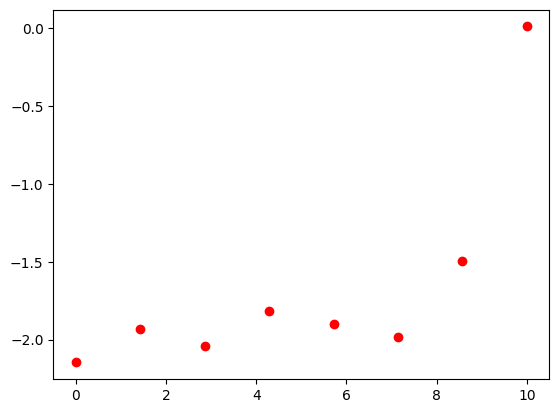

In [14]:
N = 8
noise = 0.25
lower = 0
upper = 10

x_obs = np.linspace(lower, upper, N)
y_obs = 2 * np.tanh(4 * (x_obs - upper) / upper) + noise * np.random.randn(N)

data = {
    'N': N,
    'low': lower,
    'up': upper,
    'x': x_obs,
    'y': y_obs
}

plt.scatter(x_obs, y_obs, color='red')

**Question 1.** Proposer un premier modèle de regression linéaire $y \sim \mathcal{N}(ax + b, \sigma)$.  
On cherche à estimer les paramètres $a$, $b$, et $\sigma$ (bruit).

In [15]:
regression1_code = """
data {
    int N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real a;
    real b;
    real<lower=0> sigma;
}
model {
    y ~ normal(a * x + b, sigma);
}
"""

with open("./regression1.stan", "w") as f:
    print(regression1_code, file=f)

stan_model = CmdStanModel(stan_file="regression1.stan")
stan_fit = stan_model.sample(data, chains=1)
stan_fit.summary()

15:44:18 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression1.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression1
15:44:24 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression1
15:44:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:44:25 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-0.541393,0.120577,1.749670,-4.176190,-0.058696,1.298300,210.563,8422.52,0.999540
a,0.137932,0.005582,0.083351,0.005873,0.140512,0.263685,223.002,8920.09,0.999400
b,-2.349470,0.037906,0.523441,-3.169360,-2.356520,-1.550230,190.687,7627.49,0.999779
sigma,0.723338,0.022247,0.327059,0.403659,0.644929,1.279870,216.124,8644.97,0.999019


On peut maintenant afficher quelque échantillons pour observer la distribution obtenue.

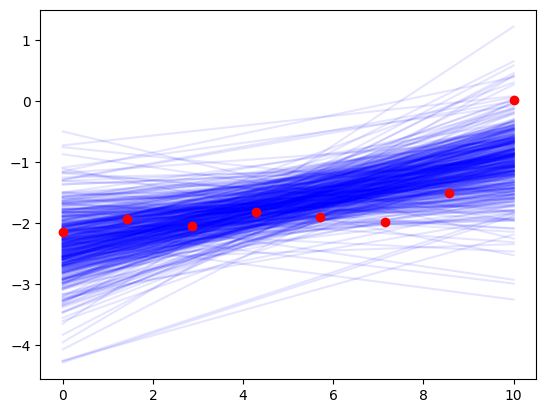

In [16]:
for i in range(500):
    x = np.linspace(lower, upper, 2)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    plt.plot(x, a * x + b, color='blue', alpha=0.1, zorder=0)
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

Le résultat correspond à nos attente, mais n'est pas formidable pour notre jeux de données où on observe une rupture de pente.

**Question 2.** Proposer un nouveau modèle avec un paramètre supplémentaire `cut` pour ce point de rupture et deux regressions : avant et après ce point.
On pourra representer les paramètres `a` et `b` par des vecteurs à 2 dimensions.

In [21]:
regression2_code = """
data {
    int N;
    real low;
    real up;
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[2] a;
    vector[2] b;
    real<lower=low, upper=up> cut;
    real<lower=0> sigma;
}
model {
    cut ~ uniform(low, up);
    for (i in 1:N){
      if (x[i] < cut) y[i] ~ normal(a[1] * x[i] + b[1], sigma);
      else y[i] ~ normal(a[2] * x[i] + b[2], sigma);
    }
}
"""

with open("./regression2.stan", "w") as f:
    print(regression2_code, file=f)

stan_model = CmdStanModel(stan_file="regression2.stan")
stan_fit = stan_model.sample(data, chains=4)
stan_fit.summary()

15:44:57 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression2.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression2
15:45:03 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression2
15:45:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:45:06 - cmdstanpy - INFO - CmdStan done processing.
15:45:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 785 divergent transitions (78.5%)
	Chain 2 had 455 divergent transitions (45.5%)
	Chain 2 had 356 iterations at max treedepth (35.6%)
	Chain 3 had 736 divergent transitions (73.6%)
	Chain 3 had 20 iterations at max treedepth (2.0%)
	Chain 4 had 738 divergent transitions (73.8%)
	Chain 4 had 77 iterations at max treedepth (7.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,4.69249,2.88262,4.630250,-4.095220,6.383240,9.93727,2.58008,1.028330,2.07900
a[1],-272.82900,303.79200,1367.310000,-4330.650000,0.048165,1067.62000,20.25720,8.073810,1.14342
a[2],37.88980,31.50630,48.679900,0.013034,17.471500,144.46100,2.38729,0.951490,3.43811
b[1],-2.15537,0.03102,0.482623,-3.027020,-2.124220,-1.50350,242.06600,96.479200,1.01921
b[2],-379.12300,314.92200,486.617000,-1444.660000,-174.756000,-1.49198,2.38763,0.951628,3.43684
cut,7.12251,2.63617,3.752540,0.192480,9.043150,9.88584,2.02630,0.807610,9.62655
sigma,0.36469,0.17563,0.315840,0.121980,0.235920,0.96954,3.23382,1.288890,1.61630


On peut à nouveau visualiser la distribution obtenue.

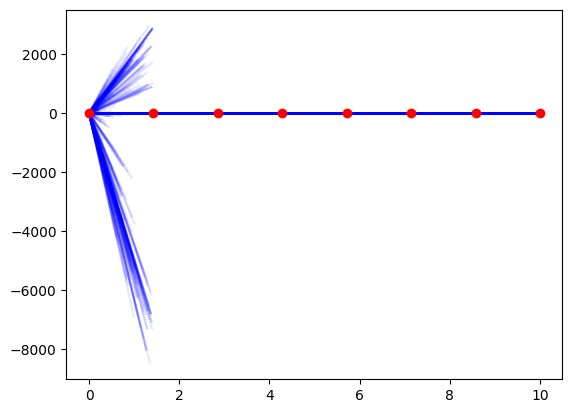

In [22]:
for i in range(500):
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    cut = stan_fit.stan_variable("cut")[i]
    x = np.linspace(lower, cut, 2)
    plt.plot(x, a[0] * x + b[0], color='blue', alpha=0.1, zorder=0)
    x = np.linspace(cut, upper, 2)
    plt.plot(x, a[1] * x + b[1], color='blue', alpha=0.1, zorder=0)
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

**Question 3.** Proposer maintenant un modèle ou le nombre (maximal) de changement de pente $C$ est donné.  
(Pour simplifier on pourra fixer la valeur du bruit $\sigma$ dans ce modèle à une valeur raisonnable).
Les points de rupture `cuts` pourront être stockés dans un vecteur trié de dimension $C$ (cf. fonction `sort_asc`).

In [17]:
regression3_code = """
data {
    int N;
    int C;
    real low;
    real up;
    vector[N] x;
    vector[N] y;
}
parameters {
    vector<lower=low, upper=up>[C] cuts_raw;
    vector[C+1] a;
    vector[C+1] b;
}
transformed parameters {
    vector[C] cuts = sort_asc(cuts_raw);
}
model {
    int j = 1;
    for (i in 1:N){
        while (j <= C && x[i] > cuts[j]) j+=1;
        y[i] ~ normal(a[j] * x[i] + b[j], 0.1);
    }
}
"""

with open("./regression3.stan", "w") as f:
    print(regression3_code, file=f)

On peut maintenant essayer le même jeu de données avec plus de rupture de pente.

In [18]:
C = 4

stan_model = CmdStanModel(stan_file="regression3.stan")
stan_fit = stan_model.sample(data = {**data, 'C':C}, chains=1)

18:14:59 - cmdstanpy - INFO - compiling stan file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression3.stan to exe file /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression3
18:15:11 - cmdstanpy - INFO - compiled model executable: /Users/gbaudart/Cours/m2-mpri/mpri-probprog/probprog-enseignants/td/td-stan/regression3
18:15:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

18:15:12 - cmdstanpy - INFO - CmdStan done processing.
18:15:12 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 988 divergent transitions (98.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


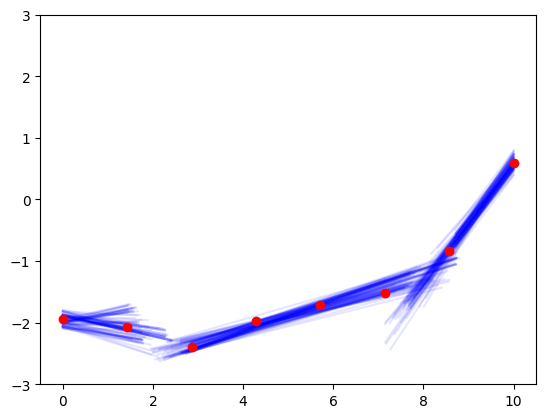

In [19]:
ax = plt.gca()
ax.set_ylim(-3, 3)
for i in range(100):
    cuts = np.append(stan_fit.stan_variable("cuts")[i], upper)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    low = lower
    for j in range(0,C+1):
        up = cuts[j]
        x = np.linspace(low, up, 2)
        plt.plot(x, a[j] * x + b[j], color='blue', alpha=0.1, zorder=0)
        low = up
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)

Et maintenant sur un jeu de données plus compliqué.

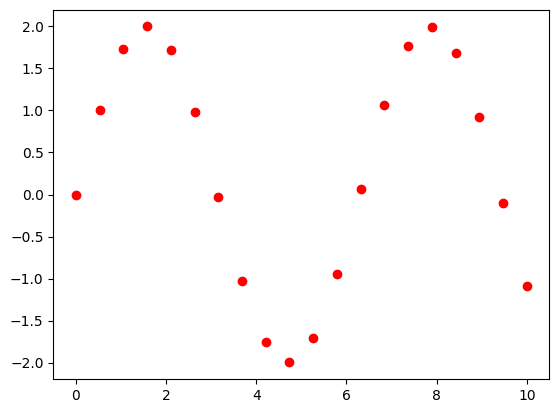

In [20]:
N = 20
x_obs = np.linspace(lower, upper, N)
y_obs = 2 * np.sin(x_obs)

data = {
    **data,
    'N': N, 
    'C': C,
    'x': x_obs,
    'y': y_obs
}

plt.scatter(x_obs, y_obs, color='red', zorder=1)

In [21]:
stan_model = CmdStanModel(stan_file="regression3.stan")
stan_fit = stan_model.sample(data, chains=1)

18:15:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

18:15:19 - cmdstanpy - INFO - CmdStan done processing.
18:15:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 995 iterations at max treedepth (99.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


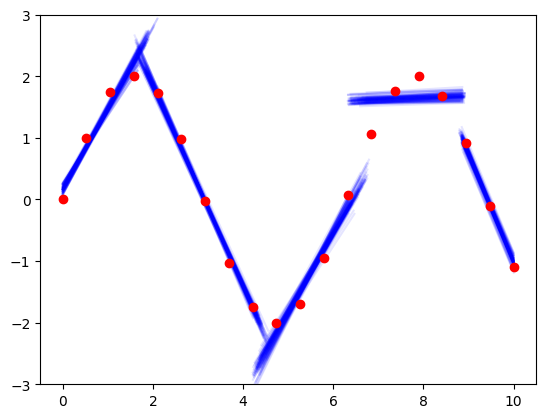

In [22]:
ax = plt.gca()
ax.set_ylim(-3, 3)
for i in range(100):
    cuts = np.append(stan_fit.stan_variable("cuts")[i], upper)
    a = stan_fit.stan_variable("a")[i]
    b = stan_fit.stan_variable("b")[i]
    low = lower
    for j in range(0,C+1):
        up = cuts[j]
        x = np.linspace(low, up, 2)
        plt.plot(x, a[j] * x + b[j], color='blue', alpha=0.1, zorder=0)
        low = up
    
plt.scatter(x_obs, y_obs, color='red', zorder=1)